# TODO:

- store output of state vars in xarray-simlab data structure
    1. for gekko solver
    2. for odeint solver
    3. for step-wise solver
    
this needs to be completely wrapped in the backend..
i need to somehow combine the "core.parts" so that they are automatically initialized with the xs.Model

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import xsimlab as xs

# to measure process time
import time as tm

In [2]:
from xsimlab.monitoring import ProgressBar

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [4]:
from phydra.processes.statevars import SV, Time

from phydra.processes.forcings import ConstantForcing

from phydra.processes.fluxes import FluxOne, ForcingInputLinearFlux

In [5]:
Model = phydra.create({
    # SV
    'y':SV,
    'x':SV, 
    
    # Fluxes
    'y_loss':FluxOne,
    'x_loss':FluxOne,
    
    # Forcing
    'y_input':ForcingInputLinearFlux,
    'N0':ConstantForcing
})

In [6]:
Model

<xsimlab.Model (9 processes, 12 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
y
    init            [in]
x
    init            [in]
N0
    value           [in]
y_loss
    sv              [in]
    rate            [in] flowing rate
x_loss
    rate            [in] flowing rate
    sv              [in]
y_input
    sv_label        [in]
    rate            [in]
    fx_label        [in]
Solver

In [7]:
#Model.visualize(show_inputs=True)

In [9]:
odeint_setup = phydra.setup('odeint', Model,
            time=np.arange(0,20,0.1),
            input_vars={
                'y__init':0.5,
                'x__init':0.5,
                
                'y_loss__sv':'y',
                'y_loss__rate':0.01,
                
                'x_loss__sv':'x',
                'x_loss__rate':0.5,
                
                'y_input':{'sv_label':'y',
                          'fx_label':'N0',
                          'rate':.1},
                'N0__value':2.
            },
            output_vars={
                'y__value':None,
                'x__value':None,
            })

In [10]:
gekko_setup = phydra.update_setup(model=Model, old_setup=odeint_setup, new_solver="gekko")

In [11]:
stepwise_setup = phydra.update_setup(model=Model, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [12]:
stepwise_setup

<xarray.Dataset>
Dimensions:            (clock: 200, input_time: 200)
Coordinates:
  * clock              (clock) float64 0.0 0.1 0.2 0.3 ... 19.6 19.7 19.8 19.9
Dimensions without coordinates: input_time
Data variables:
    y__init            float64 0.5
    x__init            float64 0.5
    y_loss__sv         <U1 'y'
    y_loss__rate       float64 0.01
    x_loss__sv         <U1 'x'
    x_loss__rate       float64 0.5
    y_input__sv_label  <U1 'y'
    y_input__fx_label  <U2 'N0'
    y_input__rate      float64 0.1
    N0__value          float64 2.0
    Time__time         (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    Core__solver_type  <U8 'stepwise'
Attributes:
    __xsimlab_output_vars__:  y__value,x__value

and solve the model like this:

In [13]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=Model)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing forcing N0
initializing flux y_loss
initializing flux x_loss
initializing flux y_input
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.00179 seconds
here unpacking values time
here unpacking values y
here unpacking values x
finalizing: cleanup


In [14]:
out_ds

<xarray.Dataset>
Dimensions:            (clock: 2, input_time: 200, time: 200)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type  <U6 'odeint'
    N0__value          float64 2.0
    Time__time         (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    x__init            float64 0.5
    x__value           (time) float64 0.5 0.4756 0.4524 ... 2.509e-05 2.386e-05
    x_loss__rate       float64 0.5
    x_loss__sv         <U1 'x'
    y__init            float64 0.5
    y__value           (time) float64 0.5 0.5195 0.539 ... 3.987 4.003 4.019
    y_input__fx_label  <U2 'N0'
    y_input__rate      float64 0.1
    y_input__sv_label  <U1 'y'
    y_loss__rate       float64 0.01
    y_loss__sv         <U1 'y'

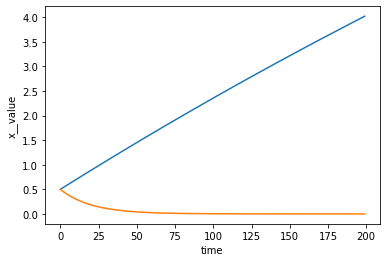

In [15]:
out_ds.y__value.plot()
out_ds.x__value.plot()

In [16]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=Model)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing forcing N0
initializing flux y_loss
initializing flux x_loss
initializing flux y_input
assembling model
SOLVER : gekko
Model was solved in 0.15 seconds
finalizing: cleanup


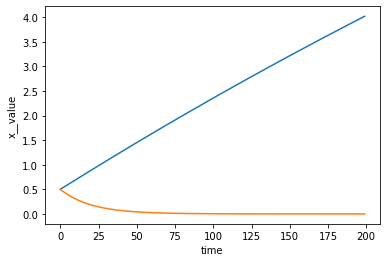

In [17]:
out_ds1.y__value.plot()
out_ds1.x__value.plot()

In [18]:
with ProgressBar(frontend="console"):
        out_ds2 = stepwise_setup.xsimlab.run(model=Model)

██████▉     70% | run step 139/199 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing forcing N0
initializing flux y_loss
initializing flux x_loss
initializing flux y_input
assembling model
SOLVER : stepwise


██████████ 100% | Simulation finished in 00:00 


finalizing: cleanup


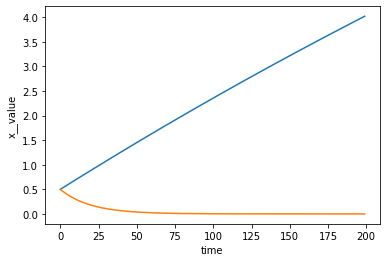

In [19]:
out_ds2.y__value.plot()
out_ds2.x__value.plot()

In [37]:
def testdecorator(arg):
    
    @xs.process
    class TEST:
        val = xs.variable(intent='out')
        
        def flux(self):
            print("S")
        
    return TEST


@xs.process
class LinearFlux(ThirdInit):
    """represents a flux in the model"""

    sv_label = xs.variable(intent='in')
    rate = xs.variable(intent='in')

    def initialize(self):
        super(LinearFlux, self).initialize()  # handles initialization stages
        print(f"initializing flux {self.label}")

        # setup parameter
        self.m.Parameters[self.label + '_rate'] = Parameter(name=self.label + '_rate', value=self.rate)
        # create flux
        self.m.Fluxes[self.sv_label].append(self.flux)

In [38]:
@testdecorator
def testfunc():
    pass

In [39]:
xs.process_info(testfunc)

<TEST  (xsimlab process)>
Variables:
    val        [out]
Simulation stages:
    *no stage implemented*
